# Character-Level Bigram Model

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/inefficient-networks/blob/master/docs/notebooks/tensorflow/05-tensorflow-cnn.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/inefficient-networks?style=social)](https://github.com/particle1331/inefficient-networks)

---

## Introduction

This notebook is based on [this tutorial](https://www.youtube.com/watch?v=PaCmpygFfXo) by [Andrej Karpathy](https://karpathy.ai/) on language modeling. In this tutorial, we use a dataset of names to train a bigram character-level language model. This model can be used to generate new names using a Markov process. The focus is on introducing the overall framework of language modeling that includes probabilistic modeling, model training, sampling, and the evaluation of models using a loss function (e.g. the negative log-likelihood for classification). 

Probabilities of bigrams will be modeled by (1) counting and (2) using a simple neural network with a single hidden layer. Models developed for this task will, in further tutorials, complexify incrementally up to the modern [Transformer](https://arxiv.org/abs/1706.03762) language model (such as [GPT](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)).

In [1]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline

DATASET_DIR = Path("./data").absolute()
RANDOM_SEED = 42

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

## Names dataset

First, we get the dataset of names that we will model:

In [2]:
words = open(DATASET_DIR / 'names.txt', 'r').read().splitlines()
print(len(words))
words[:10]

32033


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

A name is simply a sequence of characters. The task of **language modeling** is to assign probabilities to a sequence of characters. Our dataset which consists of over 32,000 names has a lot of structure both local (character level) and global (name level).

Note that our names are not infinite sequences &mdash; it has a start and an end. So we have to have tokens for these delimiters. Moreover, most names have zero probability of occuring, i.e. names with the end token before the start token. We will develop a weak model which essentially models a [Markov process](https://en.wikipedia.org/wiki/Markov_chain) of length 1. To do this, we will use **bigrams**. Bigrams of the first name in the dataset are: 

In [3]:
for w in words[:1]:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        print(c1, c2)

<S> e
e m
m m
m a
a <E>


Getting all bigrams for all names:

In [4]:
b = {}
for w in words:
    chs = ['<S>'] + list(w) + ['<E>']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        bigram = (c1, c2)
        b[bigram] = b.get(bigram, 0) + 1

The following bigrams occur most frequently. For instance, `a` occurs as the first letter in 4410 names. And most names end with `n` and `a`. 

In [5]:
sorted(b.items(), key=lambda kv: -kv[1])[:20]

[(('n', '<E>'), 6763),
 (('a', '<E>'), 6640),
 (('a', 'n'), 5438),
 (('<S>', 'a'), 4410),
 (('e', '<E>'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('<S>', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('<S>', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '<E>'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('<S>', 'j'), 2422)]

## Counting bigrams

To structure the data better, we use a 2D array. An entry `[i, j]` in this array is the count of bigrams that start with the `i`th character followed by the `j`th character. Also, we incorporate the fact that a single delimiter suffices. That is, we can use a `.` to signify the start of a name which will be closed by another `.` to signify the end of a name. Iterating over all names to get all existing bigrams:

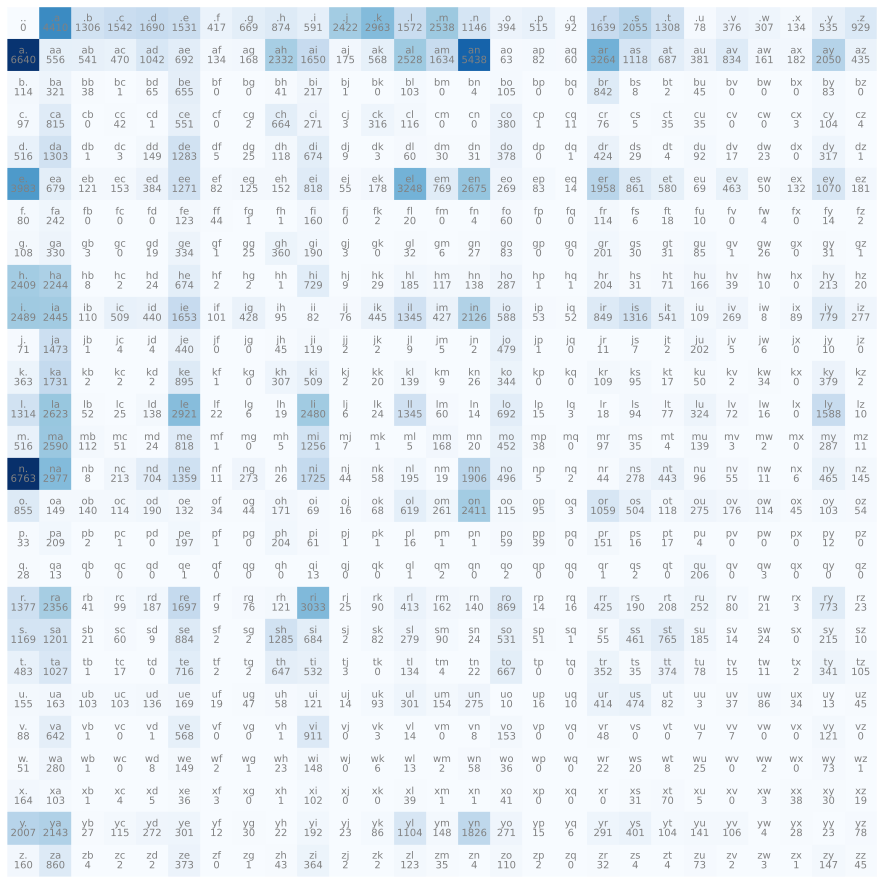

In [6]:
import torch

# Create count matrix
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s: i for i, s in enumerate(chars)}
n = len(chars)
N = torch.zeros((n, n), dtype=torch.int32)

for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        N[stoi[c1], stoi[c2]] += 1

# Visualize count matrix
itos = {i: s for s, i in stoi.items()}
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap='Blues')
for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')

plt.axis('off');

### Generating names

Already at this point we can generate names. Recall that to model joint distributions, we can use a [chain of probabilities](https://d2l.ai/chapter_recurrent-neural-networks/sequence.html#markov-models). But conditioning only on the last character as a form of truncation. First, we sample the first character from the distribution conditioned on the start token. Going from there, we sample each character conditioned on the previous sampled character until we reach the end token.

In [7]:
def generate_names(P, n, seed=2147483647):
    """Generate names from a Markov process with cond. probability table P."""

    g = torch.Generator().manual_seed(seed)
    names = []
    for _ in range(n):
        i = 0
        out = []
        while True:
            i = torch.multinomial(P[i], num_samples=1, replacement=True, generator=g).item()
            out.append(itos[i])
            if i == 0:
                break    
        names.append(''.join(out[:-1]))
    return names

Generating names from the conditional distributions that were estimated by counting:

In [8]:
P = N / N.sum(dim=1, keepdim=True)
[print(name) for name in generate_names(P, 10)];

mor
axx
minaymoryles
kondlaisah
anchshizarie
odaren
iaddash
h
jhinatien
egushl


Note that modeling using bigrams is pretty bad. But it still looks better than random. One reason this is bad is that the next most probable bigram has probability that drops exponentially from the last. This is known as [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law). Interestingly, [this holds](https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html#exploratory-language-statistics) even for trigrams, and even for word-level language modeling.

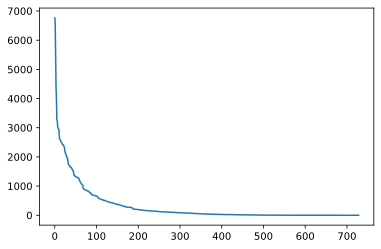

In [9]:
plt.plot(sorted(N.reshape(-1), reverse=True));

### Model quality: MLE = NLL loss

The [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) of a dataset is the probability assigned by the model on that dataset. This can be expressed as a product of likelihood of data points assuming independence. Since a product of many small positive numbers quickly vanishes to zero, we typically take the **log-likelihood** which converts this product into a sum.

[Maximum likelihood estimation](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/maximum-likelihood.html#the-maximum-likelihood-principle) (MLE) means choosing the model parameters (e.g. assignment of probabilities) such that the likelihood of the dataset is maximized. Observe that MLE is equivalent to minimizing the **negative log-likelihood** (NLL) which is a positive function. Hence, we take the NLL as our loss function. Note that we take the mean to normalize the loss value over the size of the dataset.

In [10]:
class BigramModel:
    def __init__(self):
        """
        Sequence model that uses bigrams / Markov process 
        for estimating probability of next char: P(b | a).
        """
        self.P = None  # cond. prob
        self.N = None  # counts

    def __call__(self, x: int) -> list[float]:
        return torch.tensor([self.P[x, y] for y in range(27)])

    def fit(self, xs, ys):
        self.N = torch.zeros((27, 27), dtype=torch.int32)
        for x, y in zip(xs, ys):
            self.N[x, y] += 1

        self.P = self.N / self.N.sum(dim=1, keepdim=True)

Training the model on input and target sequences:

In [11]:
xs, ys = [], []
for w in words:
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        xs.append(stoi[c1])
        ys.append(stoi[c2])

# Fitting the bigram model
bigram_model = BigramModel()
bigram_model.fit(xs, ys)

Computing the NLL of bigram model:

In [12]:
log_likelihood = 0.0
n = 0
for x, y in zip(xs, ys):
    p = bigram_model(x)[y]
    log_p = torch.log(p)
    log_likelihood += log_p
    n += 1
    if n < 12:
        print(f'{itos[y]}    {itos[x]}{itos[y]}    p={p:.4f}    nll={-log_p:.4f}')

nll = -log_likelihood
print(f"nll = {nll / n:.4f} (overall)")

e    .e    p=0.0478    nll=3.0408
m    em    p=0.0377    nll=3.2793
m    mm    p=0.0253    nll=3.6772
a    ma    p=0.3899    nll=0.9418
.    a.    p=0.1960    nll=1.6299
o    .o    p=0.0123    nll=4.3982
l    ol    p=0.0780    nll=2.5508
i    li    p=0.1777    nll=1.7278
v    iv    p=0.0152    nll=4.1867
i    vi    p=0.3541    nll=1.0383
a    ia    p=0.1381    nll=1.9796
nll = 2.4541 (overall)


Observe that a model that assigns a probability of `1.0` for each next actual character has an NLL of exactly `0.0`. Here our bigram model gets penalized for next characters whose bigrams from the previous character occurs rarely on the training dataset.

### Smoothing

Note that the penalty can even result in `+inf` loss when this encounters a bigram with zero counts in the training data, e.g. the name `gopde` since the bigram `pd` never appears on the training data. One way to fix this is to perform **model smoothing**. This can be done by adding a fixed constant to the counts:

```python
a = 2
P = (N + a).float() / (N + a).sum(dim=1, keepdim=True)
```

The larger the constant `a`, the more uniform the resulting probabilities are. Hence, the term smoothing. 

## Modeling probabilities with a neural network

Our next model still uses bigrams, but the assignment of conditional probabilities is estimated by initializing random weights which is fine-tuned using gradient descent such that the probabilities of the actual next characters are maximized. 

Recall that a network layer typically involves multiplication between the input vector and the weights matrix. A way to do this is to encode indices as one-hot vectors. We design our neural network to have a single layer with weights of size `(27, 27)` that corresponds to the count matrix above. The relevant row of the weights matrix is picked out by matrix multiplying with the one-hot input vector.

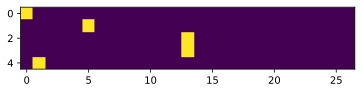

In [13]:
import torch.nn.functional as F

xs = torch.tensor(xs)
ys = torch.tensor(ys)

xenc = F.one_hot(xs, num_classes=27).float() # convert to float
plt.imshow(xenc[:5, :]); # 0, 5, 13, 13, 1, ...

In [14]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

(xenc @ W).shape

torch.Size([228146, 27])

Note that the weights with values in `(-inf, +inf)` are interpreted as log-counts which are then exponentiated to get units of count that have values in `(0, +inf)`. These values are normalized to get an output vector with values in `(0, 1)` which we interpret as a probability distribution. This is actually just taking the softmax of the row of weights. Training the network will make these interpretations valid.

In [15]:
class NNBigramModel:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        xenc = F.one_hot(xs, num_classes=27).float()
        logits = xenc @ self.W                         # init => log-counts
        counts = logits.exp()                          # .exp() => counts
        probs = counts / counts.sum(1, keepdim=True)   # normalizing => probability
        return probs
        
    def zero_grad(self):
        self.W.grad = None

    def optim_step(self, lr):
        self.W.data -= lr * self.W.grad


```{figure} ../../img/bigram-nn.drawio.svg
---
width: 450px
name: bigram-nn.drawio
---

Schematic diagram of the bigram neural net. Computing the probability assigned by the model on `b` given `a` which is represented here as one-hot vector. Note that this is also the backward dependence for a bigram `ab` encountered during training with the NLL loss.
```

**Remark.** Note that the output of the model is specified by 729 numbers, i.e. one distribution over the characters for each character. This is a pretty weak model (essentially a lookup table). What will change with further networks is how to compute and assign probabilities to the next character. This will require more complex neural network architecture that reflect a different prior for the character dependencies.

### Model training

This should converge to a similar loss value as the bigram counting model (same capacity):

In [16]:
model = NNBigramModel()

losses = []
num_steps = 100
for k in range(num_steps):
    probs = model(xs)
    loss = -probs[torch.arange(len(ys)), ys].log().mean()  # next char nll

    model.zero_grad()
    loss.backward()
    model.optim_step(lr=50.0)
    
    # logging
    losses.append(loss.item())
    if k % 10 == 9:
        print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

[010/100]   loss=2.7115
[020/100]   loss=2.5794
[030/100]   loss=2.5332
[040/100]   loss=2.5103
[050/100]   loss=2.4971
[060/100]   loss=2.4887
[070/100]   loss=2.4829
[080/100]   loss=2.4787
[090/100]   loss=2.4754
[100/100]   loss=2.4729


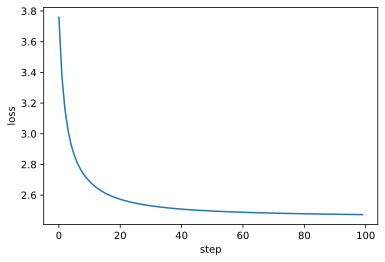

In [17]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('step');

### Sampling

The generated names of the neural net looks familiar:

In [18]:
counts = model.W.exp()
P_nn = counts / counts.sum(dim=1, keepdim=True)
[print(n) for n in generate_names(P_nn, n=10)];

mor
axwaninaymoryles
kondmaisah
anchshizarie
odaren
iaddash
h
jionatien
egwver
ga


Conditional distributions are easier to visualize:

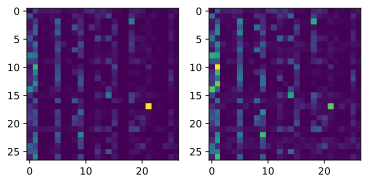

In [19]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(bigram_model.P)
ax[1].imshow(P_nn.data);

It looks like the neural net recovered something similar to the true count matrix!

### Regularization

Observe that smoothing the count matrix approximates to it having constant entries. In the context of the neural net model, this means having a zero weight matrix so that the resulting count matrix `W.exp()` is a matrix of ones. So the more getting zero weights is incentivized in the loss function, the more uniform the resulting distribution is. This is precisely weight **regularization**. For example, we can add $\frac{\alpha}{n}\lVert \boldsymbol{\mathsf W} \rVert^2_2$ where $n = |\boldsymbol{\mathsf W}|$ to the loss function:

```python
loss += 0.1 * model.W.square().mean()
```

This acts like a force that pushes the weights to zero whenever its magnitude increases to try to reduce the NLL loss.

## Appendix: Exercises

### Exercise 1

Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss. Did it improve over a bigram model?

**Solution.** A neural net model seems more straightforward to implement.

In [20]:
from itertools import product

chars = [x + y for x, y in product(stoi.keys(), stoi.keys())]
stoi2 = {s: i for i, s in enumerate(chars)}
itos2 = {i: s for s, i in stoi2.items()}

# Input / target sequences. 
# Saving a group index for GroupKFold in E02.
xs, ys = [], []
groups = []
for i, w in enumerate(words):
    chs = ['.'] + list(w) + ['.']
    for c1, c2, c3 in zip(chs[:-2], chs[1:-1], chs[2:]):
        xs.append(stoi2[c1 + c2])
        ys.append(stoi[c3])
        groups.append(i)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

Trigram model just has more input neurons in its hidden layer:

In [21]:
class TrigramModel:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27*27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        xenc = F.one_hot(xs, num_classes=27*27).float()
        logits = xenc @ self.W
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdim=True)
        return probs
        
    def zero_grad(self):
        self.W.grad = None

    def optim_step(self, lr):
        self.W.data -= lr * self.W.grad

Model training:

In [22]:
def train_model(model, xs, ys, num_steps=100, lr=50.0):
    for k in range(num_steps):
        probs = model(xs)
        loss = -probs[torch.arange(len(ys)), ys].log().mean()

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses.append(loss.item())
        if k % 10 == 9:
            print(f"[{k+1:>03d}/{num_steps}]   loss={loss:.4f}")

    return losses


model = TrigramModel()
train_model(model, xs, ys);

[010/100]   loss=3.2073
[020/100]   loss=2.9296
[030/100]   loss=2.7705
[040/100]   loss=2.6678
[050/100]   loss=2.5948
[060/100]   loss=2.5393
[070/100]   loss=2.4950
[080/100]   loss=2.4587
[090/100]   loss=2.4283
[100/100]   loss=2.4025


It improved! (Previous best is `nll=2.4541`).

### Exercise 2

Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

**Solution.** Modifying our training function to include testing and validation:

In [23]:
def nll_loss(model, xs, ys):
    probs = model(xs)
    n = len(ys)
    return -probs[torch.arange(n), ys].log().mean()


def train_model(
        model, 
        xs, ys, 
        xs_dev, ys_dev, 
        xs_tst, ys_tst,
        num_steps=100, 
        lr=50.0,
        loss_fn=nll_loss,
        eval_fn=None,
        verbose=True
    ):
    
    if eval_fn is None:
        eval_fn = loss_fn

    losses_trn = {}
    losses_dev = {}

    for k in range(num_steps):
        loss = loss_fn(model, xs, ys)

        model.zero_grad()
        loss.backward()
        model.optim_step(lr=lr)

        # logging
        losses_trn[k] = loss.item()
        if k % 10 == 9:
            loss_dev = eval_fn(model, xs_dev, ys_dev)
            losses_dev[k] = loss_dev.item()
            if verbose:
                print(f"[{k+1:>03d}/{num_steps}]    loss={loss:.4f}    dev_loss={loss_dev:.4f}")
    
    loss_test = eval_fn(model, xs_tst, ys_tst).item()
    if verbose:
        print(f'test_loss={loss_test:.4f}')
    
    return {"loss_trn": losses_trn, "loss_dev": losses_dev, "loss_tst": loss_test}

Note that we split using [GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) so that bigrams coming from same names are placed in the same fold. First, let us look at the previous bigram NN model. 

In [24]:
from sklearn.model_selection import GroupKFold


def create_group_folds(xs, ys, groups):
    gkf = GroupKFold(n_splits=10)
    folds = torch.zeros_like(xs)
    for fold, (trn_, val_) in enumerate(gkf.split(xs, ys, groups)):
        folds[val_] = fold

    xs_trn, ys_trn = xs[folds >  1], ys[folds >  1]
    xs_dev, ys_dev = xs[folds == 1], ys[folds == 1]
    xs_tst, ys_tst = xs[folds == 0], ys[folds == 0]

    return xs_trn, ys_trn, xs_dev, ys_dev, xs_tst, ys_tst


xs_, ys_ = [], []
groups_ = []
for i, w in enumerate(words):
    chs = ['.'] + list(w) + ['.']
    for c1, c2 in zip(chs[:-1], chs[1:]):
        xs_.append(stoi[c1])
        ys_.append(stoi[c2])
        groups_.append(i)

xs_ = torch.tensor(xs_)
ys_ = torch.tensor(ys_)


hist_bigram = train_model(
    NNBigramModel(), 
    *create_group_folds(xs_, ys_, groups_)
)

[010/100]    loss=2.7115    dev_loss=2.6979
[020/100]    loss=2.5797    dev_loss=2.5788
[030/100]    loss=2.5333    dev_loss=2.5346
[040/100]    loss=2.5105    dev_loss=2.5125
[050/100]    loss=2.4973    dev_loss=2.4996
[060/100]    loss=2.4889    dev_loss=2.4913
[070/100]    loss=2.4831    dev_loss=2.4856
[080/100]    loss=2.4788    dev_loss=2.4814
[090/100]    loss=2.4756    dev_loss=2.4782
[100/100]    loss=2.4730    dev_loss=2.4758
test_loss=2.4700


Comparing this with the trigram model:

In [25]:
xs_trn, ys_trn, \
xs_dev, ys_dev, \
xs_tst, ys_tst = create_group_folds(xs, ys, groups)


hist_trigram = train_model(
    TrigramModel(),
    xs_trn, ys_trn, 
    xs_dev, ys_dev, 
    xs_tst, ys_tst
)

[010/100]    loss=3.2084    dev_loss=3.1711
[020/100]    loss=2.9292    dev_loss=2.9141
[030/100]    loss=2.7695    dev_loss=2.7653
[040/100]    loss=2.6664    dev_loss=2.6685
[050/100]    loss=2.5932    dev_loss=2.5993
[060/100]    loss=2.5374    dev_loss=2.5464
[070/100]    loss=2.4930    dev_loss=2.5042
[080/100]    loss=2.4566    dev_loss=2.4697
[090/100]    loss=2.4262    dev_loss=2.4409
[100/100]    loss=2.4003    dev_loss=2.4164
test_loss=2.4063


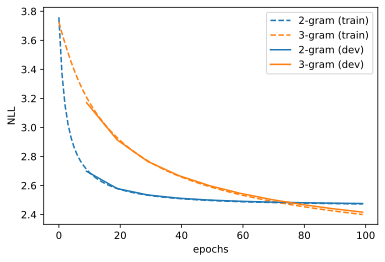

In [26]:
plt.plot(hist_bigram ['loss_trn'].keys(), hist_bigram ['loss_trn'].values(), color=f'C0', linestyle='dashed', label="2-gram (train)")
plt.plot(hist_trigram['loss_trn'].keys(), hist_trigram['loss_trn'].values(), color=f'C1', linestyle='dashed', label="3-gram (train)")

plt.plot(hist_bigram ['loss_dev'].keys(), hist_bigram ['loss_dev'].values(), color=f'C0', label="2-gram (dev)")
plt.plot(hist_trigram['loss_dev'].keys(), hist_trigram['loss_dev'].values(), color=f'C1', label="3-gram (dev)")

plt.ylabel('NLL')
plt.xlabel('epochs')
plt.legend();

Using trigrams seem to result in better generalization. This can be expected since trigrams include more context (i.e. one more character) to predict the next word. Although, the trigram model is more difficult to train as it requires learning $27^3$ probabilities. Indeed, we see from the loss curves that the trigram model converges more slowly!

### Exercise 4 & 5

**a**) Our 1-hot vectors merely select a row of `W`, so producing these vectors explicitly feels wasteful. Can you delete our use of `F.one_hot` in favor of simply indexing into rows of `W`? **b**) Also look up and use `F.cross_entropy` instead. You should achieve the same result. Can you think of why we would prefer to use this instead than the usual NLL loss?

<br>

**Solution.** Exercise 3 requires tuning, so we start with this exercise first to get faster models. Our solution is to simply index the rows of the weights matrix using the input tensor of indices, and use `F.cross_entropy` on the logits. 

In [27]:
class TrigramModelEfficient:
    def __init__(self, seed=2147483647):
        self.g = torch.Generator().manual_seed(seed)
        self.W = torch.randn((27*27, 27), generator=self.g, requires_grad=True)

    def __call__(self, xs: list[int]) -> list[float]:
        logits = self.W[xs]
        return logits
        
    def zero_grad(self):
        self.W.grad = None

    def optim_step(self, lr):
        self.W.data -= lr * self.W.grad


def cross_entropy_loss(model, xs, ys):
    return F.cross_entropy(model(xs), ys)


train_model(
    TrigramModelEfficient(), 
    xs_trn, ys_trn, 
    xs_dev, ys_dev, 
    xs_tst, ys_tst,
    loss_fn=cross_entropy_loss
);

[010/100]    loss=3.2084    dev_loss=3.1711
[020/100]    loss=2.9292    dev_loss=2.9141
[030/100]    loss=2.7695    dev_loss=2.7653
[040/100]    loss=2.6664    dev_loss=2.6685
[050/100]    loss=2.5932    dev_loss=2.5993
[060/100]    loss=2.5374    dev_loss=2.5464
[070/100]    loss=2.4930    dev_loss=2.5042
[080/100]    loss=2.4566    dev_loss=2.4697
[090/100]    loss=2.4262    dev_loss=2.4409
[100/100]    loss=2.4003    dev_loss=2.4164
test_loss=2.4063


**a**) Note that this is precisely the same results as in the implementation of the trigram model above (Exercise 2). This also shows that applying `F.cross_entropy` to the logits is equivalent to NLL with softmax probabilities. But this is super fast: 10x faster than the previous implementation. 

**b**) Using cross-entropy loss on logits avoids potential overflow with exponentials. Notice that the final expression is more numerically stable by forcing the largest exponential to be 1 (even if some of the other terms underflow):

$$
\begin{aligned}
\log \left( \frac {e^{\mathsf s_i}}{\sum_{j} e^{\mathsf s_j}} \right) 
&= {\mathsf s}_i - \log \left( {\sum_{j} e^{\mathsf s_j}} \right) \\
&= {\mathsf s}_i - {\mathsf s}_{j^*} - \log \left( \sum_{j} e^{{\mathsf s}_j - {\mathsf s}_{j^*}} \right)
\end{aligned}$$

where $j^* = {\text{arg max}}_j\; {\mathsf s}_j.$ For general classification problems, perhaps not for generating names, it suffices to use the logits to choose the class with maximum predict probability because softmax is monotonic. Hence, allowing us to skip computing the softmax entirely during inference.

### Exercise 3 

Use the dev set to tune the strength of smoothing (or regularization) for the trigram model &mdash; i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?


**Solution.** We define a function that adds regularization to the loss. Note that we still use NLL loss for evaluation.

test_nll=2.4062
test_nll=2.4060
test_nll=2.4036
test_nll=2.4079
test_nll=2.7302
test_nll=3.1823


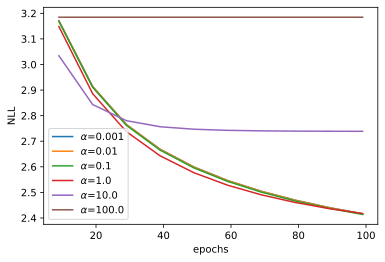

In [28]:
from functools import partial

def regularized_ce_loss(model, xs, ys, alpha):
    loss = cross_entropy_loss(model, xs, ys)
    reg = alpha * model.W.square().mean()
    return loss + reg
    

for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0]):
    model = TrigramModelEfficient()
    history = train_model(
        model, 
        xs_trn, ys_trn, 
        xs_dev, ys_dev, 
        xs_tst, ys_tst,
        loss_fn=partial(regularized_ce_loss, alpha=alpha),
        eval_fn=cross_entropy_loss,
        verbose=False
    )
    plt.plot(history['loss_dev'].keys(), history['loss_dev'].values(), color=f'C{i}', label=r'$\alpha$='+f"{alpha}")
    print(f"test_nll={history['loss_tst']:.4f}") # Not including reg.
    
plt.ylabel('NLL')
plt.xlabel('epochs')
plt.legend();

As discussed above, the stronger the regularization, the more uniform the output distributions become. Hence, we tend to get worse performing models. Indeed, we see that the test loss generally converges to worse values as we increase $\alpha$ which controls the strength of regularization. It approaches the NLL for a model that assigns the same probability to all ${n}$ characters $-\log \frac{1}{{n}} = \log {n}.$

In [29]:
import math
math.log(27.0)

3.295836866004329